In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from tqdm import tqdm

MAIN_DIR = "drive/MyDrive/FaceRecognition/Daniel's coret-coret"
os.chdir(MAIN_DIR)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from utils.data_processor import *
from utils.callback import *
from utils.train import *

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Preparing Splitting Data, Dataset, and Data Loader

In [ ]:
MAIN = 'Datasets/'
mapping_gender = pd.read_csv(MAIN + 'gender_classification.csv')
imgs_ = os.listdir(MAIN + 'Images/')
print(mapping_gender.shape)

(10000, 2)


In [ ]:
## if test and train folder already exist, no need to run this cell!
# trainTestSplit(genderClassification = mapping_gender, datasetDir= MAIN)

Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/2000 [00:00<?, ?it/s]

SPLITTING DONE!


In [ ]:
PROCESSED_IMGS_DIR = MAIN + 'Processed_Images/'
BATCH = 128
CROP_SIZE = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(CROP_SIZE, scale= (.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor()
])

train_set, trainLoader, test_set, testLoader = dataLoader(trainDir = PROCESSED_IMGS_DIR + 'Train',
                                                          testDir = PROCESSED_IMGS_DIR + 'Test',
                                                          transformer = [train_transform, test_transform],
                                                          batch_size = BATCH,
                                                          shuffle = [True, False],
                                                          num_workers = 4
                                                          )

torch.Size([128, 3, 224, 224]) torch.Size([128])


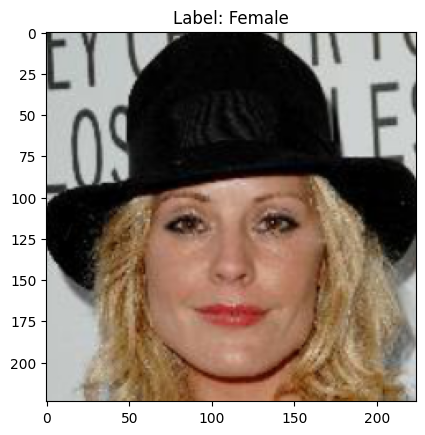

In [ ]:
feature, target = next(iter(testLoader))
print(feature.shape, target.shape)
plt.imshow(feature[0].permute(1,2,0))
plt.title(f"Label: {'Male' if target[0] == 1 else ('Female')}")
plt.show()

In [ ]:
label2cat = train_set.classes
label2cat

['Female', 'Male']

In [ ]:
config = {
    "batch_size": BATCH,
    "crop_size": CROP_SIZE
}

# Training Phase: Setting up Model, Criterion, Optimizer and Callbacks

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            ############################## FEATURE EXTRACTOR
            ## First Layer
            nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
   

            ## Second Layer
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            ## Third Layer
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


            ## 4th Layer
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            ############################### FULLY CONNECTED
            nn.Linear(12544, 512), 
            nn.ReLU(),
            nn.Dropout(.1),

            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Dropout(.1),

            nn.Linear(256, 2),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.fc (self.conv(x))

In [ ]:
model = MyCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
callback = Callback(model, config, outdir="Artifacts-BaseModel")

Train: 100%|██████████| 63/63 [09:26<00:00,  8.99s/it]


Summary Train set


train_cost: 0.6266	
train_acc: 0.6270	
train_recall: 0.3833	
train_precision: 0.5800	
train_f1-score: 0.4616	
    

Focus on: f1


Test: 100%|██████████| 16/16 [01:12<00:00,  4.56s/it]


Summary Test set


test_cost: 0.5597	
test_acc: 0.7140	
test_recall: 0.5100	
test_precision: 0.6956	
test_f1-score: 0.5885	
    

Focus on: f1

Epoch     1
Train_cost  = 0.6266 | Test_cost  = 0.5597 | Train_score = 0.4616 | Test_score = 0.5885 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]


Summary Train set


train_cost: 0.5109	
train_acc: 0.7490	
train_recall: 0.6644	
train_precision: 0.7140	
train_f1-score: 0.6883	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Summary Test set


test_cost: 0.4833	
test_acc: 0.7750	
test_recall: 0.7107	
test_precision: 0.7234	
test_f1-score: 0.7170	
    

Focus on: f1

Epoch     2
Train_cost  = 0.5109 | Test_cost  = 0.4833 | Train_score = 0.6883 | Test_score = 0.7170 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.4576	
train_acc: 0.7907	
train_recall: 0.7426	
train_precision: 0.7525	
train_f1-score: 0.7475	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Summary Test set


test_cost: 0.4219	
test_acc: 0.8110	
test_recall: 0.7195	
test_precision: 0.7904	
test_f1-score: 0.7533	
    

Focus on: f1

Epoch     3
Train_cost  = 0.4576 | Test_cost  = 0.4219 | Train_score = 0.7475 | Test_score = 0.7533 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.3836	
train_acc: 0.8277	
train_recall: 0.7803	
train_precision: 0.8015	
train_f1-score: 0.7908	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


Summary Test set


test_cost: 0.3580	
test_acc: 0.8410	
test_recall: 0.8741	
test_precision: 0.7636	
test_f1-score: 0.8151	
    

Focus on: f1

Epoch     4
Train_cost  = 0.3836 | Test_cost  = 0.3580 | Train_score = 0.7908 | Test_score = 0.8151 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Summary Train set


train_cost: 0.3266	
train_acc: 0.8582	
train_recall: 0.8298	
train_precision: 0.8303	
train_f1-score: 0.8300	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Summary Test set


test_cost: 0.3112	
test_acc: 0.8665	
test_recall: 0.7481	
test_precision: 0.9023	
test_f1-score: 0.8180	
    

Focus on: f1

Epoch     5
Train_cost  = 0.3266 | Test_cost  = 0.3112 | Train_score = 0.8300 | Test_score = 0.8180 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Summary Train set


train_cost: 0.2713	
train_acc: 0.8850	
train_recall: 0.8663	
train_precision: 0.8591	
train_f1-score: 0.8627	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


Summary Test set


test_cost: 0.2617	
test_acc: 0.9005	
test_recall: 0.8217	
test_precision: 0.9217	
test_f1-score: 0.8688	
    

Focus on: f1

Epoch     6
Train_cost  = 0.2713 | Test_cost  = 0.2617 | Train_score = 0.8627 | Test_score = 0.8688 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]


Summary Train set


train_cost: 0.2333	
train_acc: 0.9011	
train_recall: 0.8903	
train_precision: 0.8749	
train_f1-score: 0.8825	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


Summary Test set


test_cost: 0.2131	
test_acc: 0.9125	
test_recall: 0.8716	
test_precision: 0.9066	
test_f1-score: 0.8887	
    

Focus on: f1

Epoch     7
Train_cost  = 0.2333 | Test_cost  = 0.2131 | Train_score = 0.8825 | Test_score = 0.8887 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Summary Train set


train_cost: 0.2173	
train_acc: 0.9093	
train_recall: 0.9014	
train_precision: 0.8834	
train_f1-score: 0.8923	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Summary Test set


test_cost: 0.2143	
test_acc: 0.9120	
test_recall: 0.8666	
test_precision: 0.9097	
test_f1-score: 0.8876	
    

Focus on: f1

Epoch     8
Train_cost  = 0.2173 | Test_cost  = 0.2143 | Train_score = 0.8923 | Test_score = 0.8876 |
==> EarlyStop patience =  1 | Best test_score: 0.8887
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Summary Train set


train_cost: 0.1931	
train_acc: 0.9209	
train_recall: 0.9158	
train_precision: 0.8967	
train_f1-score: 0.9062	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Summary Test set


test_cost: 0.2083	
test_acc: 0.9205	
test_recall: 0.9027	
test_precision: 0.8994	
test_f1-score: 0.9011	
    

Focus on: f1

Epoch     9
Train_cost  = 0.1931 | Test_cost  = 0.2083 | Train_score = 0.9062 | Test_score = 0.9011 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1918	
train_acc: 0.9217	
train_recall: 0.9221	
train_precision: 0.8937	
train_f1-score: 0.9077	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Summary Test set


test_cost: 0.2340	
test_acc: 0.9115	
test_recall: 0.8192	
test_precision: 0.9536	
test_f1-score: 0.8813	
    

Focus on: f1

Epoch    10
Train_cost  = 0.1918 | Test_cost  = 0.2340 | Train_score = 0.9077 | Test_score = 0.8813 |
==> EarlyStop patience =  1 | Best test_score: 0.9011
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


Summary Train set


train_cost: 0.1698	
train_acc: 0.9315	
train_recall: 0.9254	
train_precision: 0.9117	
train_f1-score: 0.9185	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Summary Test set


test_cost: 0.1999	
test_acc: 0.9220	
test_recall: 0.8778	
test_precision: 0.9239	
test_f1-score: 0.9003	
    

Focus on: f1

Epoch    11
Train_cost  = 0.1698 | Test_cost  = 0.1999 | Train_score = 0.9185 | Test_score = 0.9003 |
==> EarlyStop patience =  2 | Best test_score: 0.9011
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s]


Summary Train set


train_cost: 0.1660	
train_acc: 0.9309	
train_recall: 0.9260	
train_precision: 0.9099	
train_f1-score: 0.9179	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Summary Test set


test_cost: 0.2017	
test_acc: 0.9260	
test_recall: 0.8691	
test_precision: 0.9419	
test_f1-score: 0.9040	
    

Focus on: f1

Epoch    12
Train_cost  = 0.1660 | Test_cost  = 0.2017 | Train_score = 0.9179 | Test_score = 0.9040 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Summary Train set


train_cost: 0.1497	
train_acc: 0.9395	
train_recall: 0.9341	
train_precision: 0.9219	
train_f1-score: 0.9280	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Summary Test set


test_cost: 0.2315	
test_acc: 0.9165	
test_recall: 0.8354	
test_precision: 0.9504	
test_f1-score: 0.8892	
    

Focus on: f1

Epoch    13
Train_cost  = 0.1497 | Test_cost  = 0.2315 | Train_score = 0.9280 | Test_score = 0.8892 |
==> EarlyStop patience =  1 | Best test_score: 0.9040
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Summary Train set


train_cost: 0.1505	
train_acc: 0.9389	
train_recall: 0.9386	
train_precision: 0.9169	
train_f1-score: 0.9276	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


Summary Test set


test_cost: 0.1970	
test_acc: 0.9260	
test_recall: 0.8791	
test_precision: 0.9325	
test_f1-score: 0.9050	
    

Focus on: f1

Epoch    14
Train_cost  = 0.1505 | Test_cost  = 0.1970 | Train_score = 0.9276 | Test_score = 0.9050 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1438	
train_acc: 0.9440	
train_recall: 0.9422	
train_precision: 0.9250	
train_f1-score: 0.9335	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Summary Test set


test_cost: 0.1733	
test_acc: 0.9370	
test_recall: 0.9040	
test_precision: 0.9367	
test_f1-score: 0.9201	
    

Focus on: f1

Epoch    15
Train_cost  = 0.1438 | Test_cost  = 0.1733 | Train_score = 0.9335 | Test_score = 0.9201 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.1327	
train_acc: 0.9483	
train_recall: 0.9479	
train_precision: 0.9295	
train_f1-score: 0.9386	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Summary Test set


test_cost: 0.2057	
test_acc: 0.9275	
test_recall: 0.8516	
test_precision: 0.9633	
test_f1-score: 0.9040	
    

Focus on: f1

Epoch    16
Train_cost  = 0.1327 | Test_cost  = 0.2057 | Train_score = 0.9386 | Test_score = 0.9040 |
==> EarlyStop patience =  1 | Best test_score: 0.9201
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1303	
train_acc: 0.9499	
train_recall: 0.9485	
train_precision: 0.9325	
train_f1-score: 0.9404	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


Summary Test set


test_cost: 0.1615	
test_acc: 0.9420	
test_recall: 0.9364	
test_precision: 0.9203	
test_f1-score: 0.9283	
    

Focus on: f1

Epoch    17
Train_cost  = 0.1303 | Test_cost  = 0.1615 | Train_score = 0.9404 | Test_score = 0.9283 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Summary Train set


train_cost: 0.1189	
train_acc: 0.9547	
train_recall: 0.9542	
train_precision: 0.9384	
train_f1-score: 0.9462	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Summary Test set


test_cost: 0.1777	
test_acc: 0.9395	
test_recall: 0.9002	
test_precision: 0.9463	
test_f1-score: 0.9227	
    

Focus on: f1

Epoch    18
Train_cost  = 0.1189 | Test_cost  = 0.1777 | Train_score = 0.9462 | Test_score = 0.9227 |
==> EarlyStop patience =  1 | Best test_score: 0.9283
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s]


Summary Train set


train_cost: 0.1253	
train_acc: 0.9499	
train_recall: 0.9476	
train_precision: 0.9333	
train_f1-score: 0.9404	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


Summary Test set


test_cost: 0.1547	
test_acc: 0.9475	
test_recall: 0.9239	
test_precision: 0.9439	
test_f1-score: 0.9338	
    

Focus on: f1

Epoch    19
Train_cost  = 0.1253 | Test_cost  = 0.1547 | Train_score = 0.9404 | Test_score = 0.9338 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]


Summary Train set


train_cost: 0.1201	
train_acc: 0.9539	
train_recall: 0.9521	
train_precision: 0.9383	
train_f1-score: 0.9451	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Summary Test set


test_cost: 0.2033	
test_acc: 0.9290	
test_recall: 0.8641	
test_precision: 0.9545	
test_f1-score: 0.9071	
    

Focus on: f1

Epoch    20
Train_cost  = 0.1201 | Test_cost  = 0.2033 | Train_score = 0.9451 | Test_score = 0.9071 |


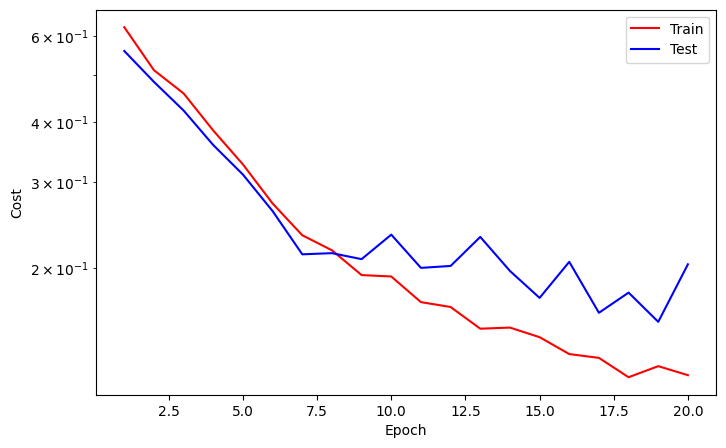

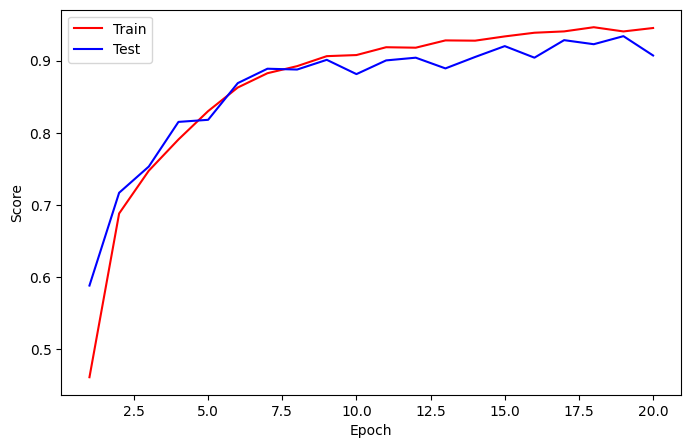

==> EarlyStop patience =  1 | Best test_score: 0.9338
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1139	
train_acc: 0.9570	
train_recall: 0.9586	
train_precision: 0.9395	
train_f1-score: 0.9490	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


Summary Test set


test_cost: 0.1670	
test_acc: 0.9430	
test_recall: 0.9090	
test_precision: 0.9468	
test_f1-score: 0.9275	
    

Focus on: f1

Epoch    21
Train_cost  = 0.1139 | Test_cost  = 0.1670 | Train_score = 0.9490 | Test_score = 0.9275 |
==> EarlyStop patience =  2 | Best test_score: 0.9338
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1050	
train_acc: 0.9591	
train_recall: 0.9583	
train_precision: 0.9445	
train_f1-score: 0.9514	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


Summary Test set


test_cost: 0.1558	
test_acc: 0.9440	
test_recall: 0.9052	
test_precision: 0.9528	
test_f1-score: 0.9284	
    

Focus on: f1

Epoch    22
Train_cost  = 0.1050 | Test_cost  = 0.1558 | Train_score = 0.9514 | Test_score = 0.9284 |
==> EarlyStop patience =  3 | Best test_score: 0.9338
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Summary Train set


train_cost: 0.1139	
train_acc: 0.9534	
train_recall: 0.9527	
train_precision: 0.9367	
train_f1-score: 0.9446	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Summary Test set


test_cost: 0.1504	
test_acc: 0.9475	
test_recall: 0.9314	
test_precision: 0.9373	
test_f1-score: 0.9343	
    

Focus on: f1

Epoch    23
Train_cost  = 0.1139 | Test_cost  = 0.1504 | Train_score = 0.9446 | Test_score = 0.9343 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.1027	
train_acc: 0.9600	
train_recall: 0.9607	
train_precision: 0.9443	
train_f1-score: 0.9525	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Summary Test set


test_cost: 0.1607	
test_acc: 0.9395	
test_recall: 0.9264	
test_precision: 0.9230	
test_f1-score: 0.9247	
    

Focus on: f1

Epoch    24
Train_cost  = 0.1027 | Test_cost  = 0.1607 | Train_score = 0.9525 | Test_score = 0.9247 |
==> EarlyStop patience =  1 | Best test_score: 0.9343
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.0999	
train_acc: 0.9646	
train_recall: 0.9652	
train_precision: 0.9507	
train_f1-score: 0.9579	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Summary Test set


test_cost: 0.1607	
test_acc: 0.9500	
test_recall: 0.9165	
test_precision: 0.9570	
test_f1-score: 0.9363	
    

Focus on: f1

Epoch    25
Train_cost  = 0.0999 | Test_cost  = 0.1607 | Train_score = 0.9579 | Test_score = 0.9363 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.0927	
train_acc: 0.9645	
train_recall: 0.9628	
train_precision: 0.9526	
train_f1-score: 0.9577	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


Summary Test set


test_cost: 0.1680	
test_acc: 0.9465	
test_recall: 0.8990	
test_precision: 0.9652	
test_f1-score: 0.9309	
    

Focus on: f1

Epoch    26
Train_cost  = 0.0927 | Test_cost  = 0.1680 | Train_score = 0.9577 | Test_score = 0.9309 |
==> EarlyStop patience =  1 | Best test_score: 0.9363
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.12it/s]


Summary Train set


train_cost: 0.0972	
train_acc: 0.9611	
train_recall: 0.9586	
train_precision: 0.9487	
train_f1-score: 0.9536	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


Summary Test set


test_cost: 0.1417	
test_acc: 0.9510	
test_recall: 0.9476	
test_precision: 0.9314	
test_f1-score: 0.9394	
    

Focus on: f1

Epoch    27
Train_cost  = 0.0972 | Test_cost  = 0.1417 | Train_score = 0.9536 | Test_score = 0.9394 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.0941	
train_acc: 0.9645	
train_recall: 0.9649	
train_precision: 0.9507	
train_f1-score: 0.9578	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Summary Test set


test_cost: 0.1384	
test_acc: 0.9525	
test_recall: 0.9302	
test_precision: 0.9503	
test_f1-score: 0.9401	
    

Focus on: f1

Epoch    28
Train_cost  = 0.0941 | Test_cost  = 0.1384 | Train_score = 0.9578 | Test_score = 0.9401 |
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]


Summary Train set


train_cost: 0.0869	
train_acc: 0.9657	
train_recall: 0.9631	
train_precision: 0.9551	
train_f1-score: 0.9591	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Summary Test set


test_cost: 0.1949	
test_acc: 0.9435	
test_recall: 0.8953	
test_precision: 0.9612	
test_f1-score: 0.9270	
    

Focus on: f1

Epoch    29
Train_cost  = 0.0869 | Test_cost  = 0.1949 | Train_score = 0.9591 | Test_score = 0.9270 |
==> EarlyStop patience =  1 | Best test_score: 0.9401
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Summary Train set


train_cost: 0.0838	
train_acc: 0.9673	
train_recall: 0.9643	
train_precision: 0.9575	
train_f1-score: 0.9609	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Summary Test set


test_cost: 0.1563	
test_acc: 0.9495	
test_recall: 0.9127	
test_precision: 0.9594	
test_f1-score: 0.9355	
    

Focus on: f1

Epoch    30
Train_cost  = 0.0838 | Test_cost  = 0.1563 | Train_score = 0.9609 | Test_score = 0.9355 |
==> EarlyStop patience =  2 | Best test_score: 0.9401
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.11it/s]


Summary Train set


train_cost: 0.0803	
train_acc: 0.9705	
train_recall: 0.9697	
train_precision: 0.9600	
train_f1-score: 0.9648	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


Summary Test set


test_cost: 0.1625	
test_acc: 0.9465	
test_recall: 0.9090	
test_precision: 0.9554	
test_f1-score: 0.9316	
    

Focus on: f1

Epoch    31
Train_cost  = 0.0803 | Test_cost  = 0.1625 | Train_score = 0.9648 | Test_score = 0.9316 |
==> EarlyStop patience =  3 | Best test_score: 0.9401
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.14it/s]


Summary Train set


train_cost: 0.0813	
train_acc: 0.9702	
train_recall: 0.9694	
train_precision: 0.9597	
train_f1-score: 0.9645	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Summary Test set


test_cost: 0.1686	
test_acc: 0.9505	
test_recall: 0.9115	
test_precision: 0.9631	
test_f1-score: 0.9366	
    

Focus on: f1

Epoch    32
Train_cost  = 0.0813 | Test_cost  = 0.1686 | Train_score = 0.9645 | Test_score = 0.9366 |
==> EarlyStop patience =  4 | Best test_score: 0.9401
------------------------------------------------------------------------------------------




Train: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Summary Train set


train_cost: 0.0825	
train_acc: 0.9700	
train_recall: 0.9658	
train_precision: 0.9624	
train_f1-score: 0.9641	
    

Focus on: f1


Test: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


Summary Test set


test_cost: 0.1524	
test_acc: 0.9435	
test_recall: 0.9613	
test_precision: 0.9039	
test_f1-score: 0.9317	
    

Focus on: f1

Epoch    33
Train_cost  = 0.0825 | Test_cost  = 0.1524 | Train_score = 0.9641 | Test_score = 0.9317 |
==> EarlyStop patience =  5 | Best test_score: 0.9401
==> Execute Early Stopping at epoch: 33 | Best test_score: 0.9401
==> Best model is saved at Artifacts-BaseModel


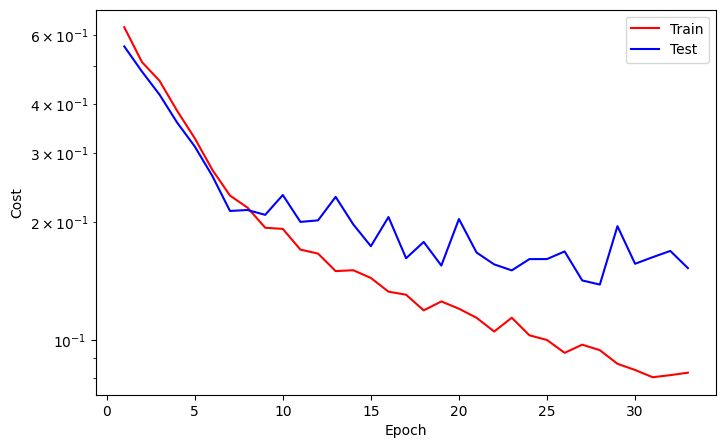

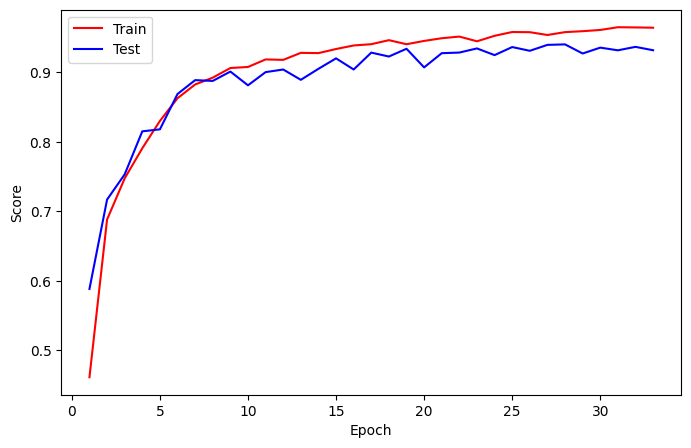

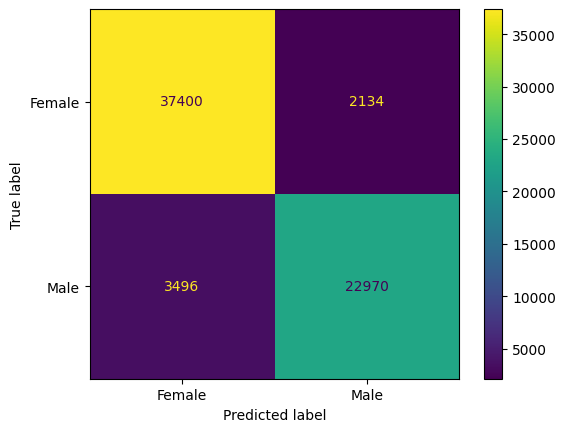

In [ ]:
def fit_predict():
  CM = 0
  while True:
      train_cost, train_score = loop_fn("train", train_set, trainLoader, model, criterion, optimizer, device, focus_on = 'f1')
      with torch.no_grad():
          test_cost, test_score, CM_test = loop_fn("test", test_set, testLoader, model, criterion, optimizer, device, focus_on = 'f1')
          CM += CM_test
        

      ## LOGGING
      callback.log(train_cost, test_cost, train_score, test_score)

      ## Checkpoint
      callback.save_checkpoint()

      ## Runtime Plotting
      callback.cost_runtime_plotting()
      callback.score_runtime_plotting()

      ## EARLY STOPPING
      if callback.early_stopping(model, monitor='test_score'):
          callback.plot_cost()
          callback.plot_score()
          break

      print(90 * "-")
      print()
      print()
  disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=label2cat)
  disp.plot()
  plt.show()

  return model

if __name__ == '__main__':
  model = fit_predict()

## Load best Weight for Base Model

In [ ]:
weights = torch.load("./Artifacts-BaseModel/weights_best.pth", map_location = 'cpu')
model = MyCNN()
model.load_state_dict(weights)
model = model.to(device)

## Predict

In [ ]:
feature, target = next(iter(testLoader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval() 
    output = model(feature)
    pred_ = output.argmax(1)

pred_

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
fig, axes = plt.subplots(6, 6, figsize = (24, 24))
for img, label, pred, ax in zip(feature, target, pred_, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {'color': 'r'} if label != pred else {'color' : 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict = font)
    ax.axis('off')

# Predict One Random Sample

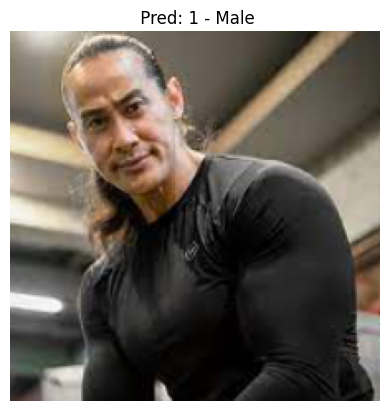

In [ ]:
PREDICT = './Datasets/Test/'
img_test1 = PREDICT + 'test1.jpg'

def predict_one_sample(input_pic, transformer, model):
  img_test1 = Image.open(input_pic)
  img_test1 = transformer(img_test1).to(device)
  with torch.no_grad():
    model.eval()
    output = model(img_test1.view(1,3,224,224))
    pred_ = output.argmax(1)

  plt.imshow(img_test1.permute(1,2,0).cpu())
  plt.title(f" Pred: {pred_.item()} - {'Male' if pred_ == 1 else ('Female')}")
  plt.axis('off')
  plt.show()

if __name__ == '__main__':
  predict_one_sample(img_test1, test_transform, model)